In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
from celluloid import Camera
from collections import deque
from matplotlib import animation

from controllers.game_controller import GameController
from drl.agent import DRLAgent
from models.players.random_player import RandomPlayer
from models.players.drl_player import DRLPlayer
from utils import get_reward_from_winner

# %matplotlib notebook
plt.rcParams['animation.ffmpeg_path'] = "C:\\FFmpeg\\bin\\ffmpeg"

In [3]:
def run_validation(drl_players, n_episodes_validation):
    game_controller = GameController()
    players = [
        drl_players[0],
        RandomPlayer(1)
    ]
    game_controller.load_validation(players)
    
    # Disable train mode
    players[0].train_mode = False

    validation_scores = []
    for i in range(1, n_episodes_validation+1):
        episode_winner = game_controller.run_episode(eval_mode=True)
        validation_score = get_reward_from_winner(0, episode_winner)
        validation_scores.append(validation_score)
        game_controller.game.reset()

    # Re-enable train mode
    players[0].train_mode = True
    
    return np.mean(validation_scores)

In [4]:
def get_critic_value(agent_critic, initial_state, bid, board_move):
    action = torch.zeros(10)
    action[0] = bid/200
    action[1+board_move] = 1
    action = action.unsqueeze(0).cuda()
    return agent_critic(initial_state, action).flatten().item()

def get_all_critic_values(drl_player, initial_state):
    agent_critic = drl_player.agent.agent.critic_local
    return [[get_critic_value(agent_critic, initial_state, bid, board_move) for bid in range(101)] \
                for board_move in range(9)]   

In [5]:
def plot_critic_values(drl_player, critic_values, fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(3, 3, figsize=(12, 8))
    for board_move in range(9):
        axx = ax[board_move//3, board_move%3]
        axx.set_xlabel('Bid value')
        axx.set_ylabel('Quality of move')
        axx.set_title(f'Board move {board_move}')
        axx.plot(critic_values[board_move])
    fig.tight_layout()
#     plt.savefig('test.png')

In [6]:
def create_animation(critic_values_by_episode, fps=10, filename='critic_values.mp4'):
    fig, ax = plt.subplots(3, 3, figsize=(12, 8))

    camera = Camera(fig)
    initial_index = 0
    while initial_index+1<len(critic_values_by_episode) and \
            critic_values_by_episode[initial_index] == critic_values_by_episode[initial_index+1]:
        initial_index += 1

    for i in range(initial_index, len(critic_values_by_episode)):
        critic_values = critic_values_by_episode[i]
        i += 1
        plot_critic_values(drl_players[0], critic_values, fig, ax);
        plt.pause(0.1)
        camera.snap()

    anim = camera.animate()
    FFwriter = animation.FFMpegWriter(fps=fps)
    anim.save(filename, writer=FFwriter);

In [29]:
def init_train(game_controller, drl_players, n_episodes, checkpoint_each, validate_each, n_episodes_validation,
                   model_path=None, save_critic_value_each=100, save_animation_each=1000, eps_start=1.0,
                   eps_end=0.01, eps_decay=0.999, start_epoch=1, critic_values_by_episode=None):

        game_controller.load_train(drl_players)
        for player in range(2):
            drl_players[player].update_epsilon(eps_start)

        if critic_values_by_episode is None:
            critic_values_by_episode = []
        initial_state = drl_players[0]._format_state_to_agent(game_controller.game.get_state_array()).cuda().unsqueeze(0)

        try:
            validation_scores = []
            validation_scores_window = deque(maxlen=100)
            eps = eps_start
            start = time.time()
            for i in range(start_epoch, start_epoch+n_episodes):
                for player in range(2):
                    game_controller.players[player].update_epsilon(eps)

                episode_winner = game_controller.run_episode(train_mode=True)
                game_controller.game.reset()

                # Update epsilon-greedy parameter
                eps = max(eps_end, eps * eps_decay)

                if i%validate_each == 0:
                    mean_validation_score = run_validation(drl_players, n_episodes_validation)

                    validation_scores.append(mean_validation_score)
                    validation_scores_window.append(mean_validation_score)
                    mean_validation_score_last_runs = np.mean(validation_scores_window)

                    try:
                        agent_losses = drl_players[0].agent.get_losses()
                        actor_loss = '{:+6.3f}'.format(agent_losses['actor_losses'][-1])
                        critic_loss = '{:+6.3f}'.format(agent_losses['critic_losses'][-1])
                    except:
                        actor_loss = '------'
                        critic_loss = '------'
                    print("\rEpisode #{:4d}  |  "
                        "Val. Score: {:+5.2f}   |  "
                        "Avg. Val. Score: {:+5.2f}  |  "
                        "Epsilon: {:5.3f}\n"
                        "                  "
                        "Actor Loss: {}  |  "
                        "Critic Loss: {}     |  "
                        "Time Elapsed: {:.2f}s".format(i, mean_validation_score,
                                            mean_validation_score_last_runs, eps,
                                            actor_loss, critic_loss, time.time() - start)
                    )

                if checkpoint_each != -1 and i%checkpoint_each == 0:
                    drl_players[0].agent.save_model(f'../checkpoints/checkpoint_episode_{i}.pt')
                    print('Checkpoint saved!')
                if save_critic_value_each != -1 and i%save_critic_value_each == 0:
                    critic_values_by_episode.append(get_all_critic_values(drl_players[0], initial_state))
                if save_animation_each != -1 and i%save_animation_each == 0:
                    create_animation(critic_values_by_episode, filename=f'critic_values_episode_{i}.mp4')
                    print('Animation of critic values saved!')
        except KeyboardInterrupt:
            pass

        # save model after all episodes
        drl_players[0].agent.save_model(model_path)
        print('Model saved!')

        return validation_scores, critic_values_by_episode

In [8]:
def plot_scores(metrics, validate_each):
    new_index = pd.RangeIndex(start=1, stop=1+len(metrics)*validate_each, step=validate_each)
    fig, ax = plt.subplots(figsize=(18,6))
    ax.plot(new_index, metrics)
    series = pd.Series(metrics)
    series.index = new_index
    series.rolling(100, 1).mean().plot(ax=ax, label='MA(100)')
    ax.set_xlabel('Episodes')
    ax.set_ylabel('Score')
    plt.show();

In [9]:
controller = GameController()
drl_agent = DRLAgent(
    state_size=controller.game.N*controller.game.N+2,
    bid_action_size=1,
    board_action_size=controller.game.N*controller.game.N,
    seed=None,
    checkpoint_path='../checkpoints/checkpoint2.pt'
)

Episode # 100  |  Val. Score: -0.50   |  Avg. Val. Score: -0.50  |  Epsilon: 0.905
                  Actor Loss: -0.061  |  Critic Loss: +0.059     |  Time Elapsed: 43.17s
Episode # 200  |  Val. Score: -0.40   |  Avg. Val. Score: -0.45  |  Epsilon: 0.819
                  Actor Loss: -0.257  |  Critic Loss: +0.057     |  Time Elapsed: 146.52s
Episode # 300  |  Val. Score: -0.60   |  Avg. Val. Score: -0.50  |  Epsilon: 0.741
                  Actor Loss: -0.533  |  Critic Loss: +0.064     |  Time Elapsed: 253.76s
Episode # 400  |  Val. Score: -0.80   |  Avg. Val. Score: -0.57  |  Epsilon: 0.670
                  Actor Loss: -0.885  |  Critic Loss: +0.119     |  Time Elapsed: 367.78s
Episode # 500  |  Val. Score: -0.30   |  Avg. Val. Score: -0.52  |  Epsilon: 0.606
                  Actor Loss: -1.243  |  Critic Loss: +0.194     |  Time Elapsed: 476.69s
Checkpoint saved!


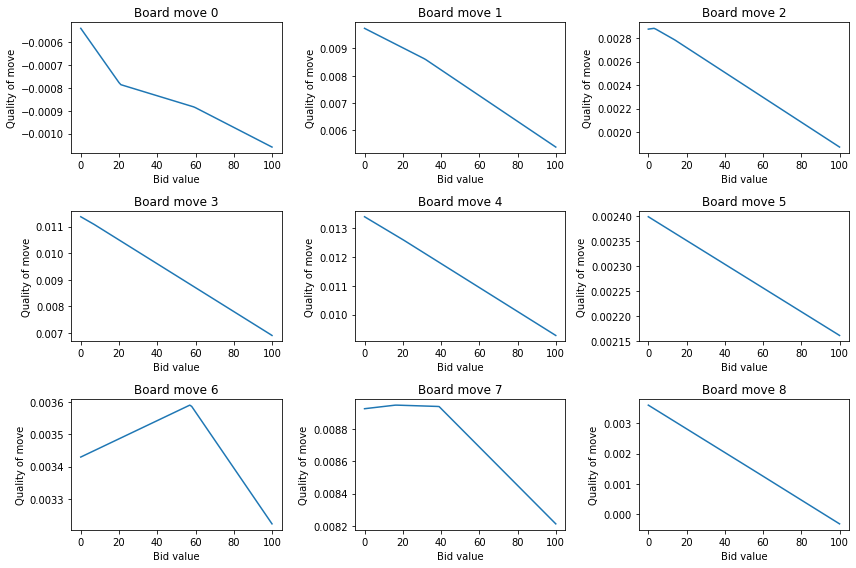

Animation of critic values saved!
Episode # 600  |  Val. Score: -0.70   |  Avg. Val. Score: -0.55  |  Epsilon: 0.549
                  Actor Loss: -1.633  |  Critic Loss: +0.307     |  Time Elapsed: 589.01s
Episode # 700  |  Val. Score: -0.20   |  Avg. Val. Score: -0.50  |  Epsilon: 0.496
                  Actor Loss: -1.944  |  Critic Loss: +0.442     |  Time Elapsed: 698.68s
Episode # 800  |  Val. Score: +0.40   |  Avg. Val. Score: -0.39  |  Epsilon: 0.449
                  Actor Loss: -2.149  |  Critic Loss: +0.572     |  Time Elapsed: 806.93s
Episode # 900  |  Val. Score: -0.40   |  Avg. Val. Score: -0.39  |  Epsilon: 0.406
                  Actor Loss: -2.254  |  Critic Loss: +0.611     |  Time Elapsed: 919.76s
Episode #1000  |  Val. Score: -0.40   |  Avg. Val. Score: -0.39  |  Epsilon: 0.368
                  Actor Loss: -2.366  |  Critic Loss: +0.660     |  Time Elapsed: 1028.22s
Checkpoint saved!


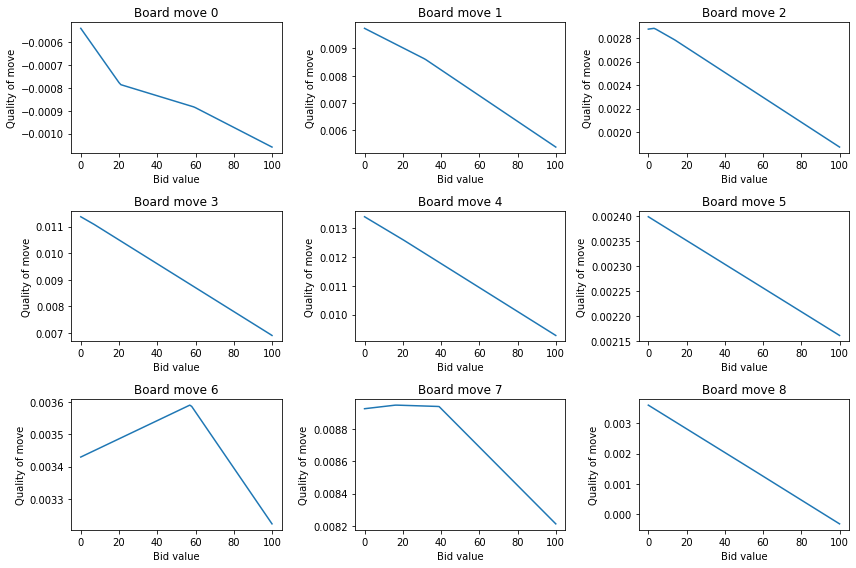

Animation of critic values saved!
Episode #1100  |  Val. Score: +0.50   |  Avg. Val. Score: -0.31  |  Epsilon: 0.333
                  Actor Loss: -2.472  |  Critic Loss: +0.717     |  Time Elapsed: 1143.48s
Episode #1200  |  Val. Score: -0.20   |  Avg. Val. Score: -0.30  |  Epsilon: 0.301
                  Actor Loss: -2.610  |  Critic Loss: +0.632     |  Time Elapsed: 1250.44s
Episode #1300  |  Val. Score: -0.30   |  Avg. Val. Score: -0.30  |  Epsilon: 0.272
                  Actor Loss: -2.628  |  Critic Loss: +0.728     |  Time Elapsed: 1357.16s
Episode #1400  |  Val. Score: -0.60   |  Avg. Val. Score: -0.32  |  Epsilon: 0.246
                  Actor Loss: -2.713  |  Critic Loss: +0.873     |  Time Elapsed: 1462.43s
Episode #1500  |  Val. Score: -0.60   |  Avg. Val. Score: -0.34  |  Epsilon: 0.223
                  Actor Loss: -2.773  |  Critic Loss: +1.041     |  Time Elapsed: 1574.79s
Checkpoint saved!


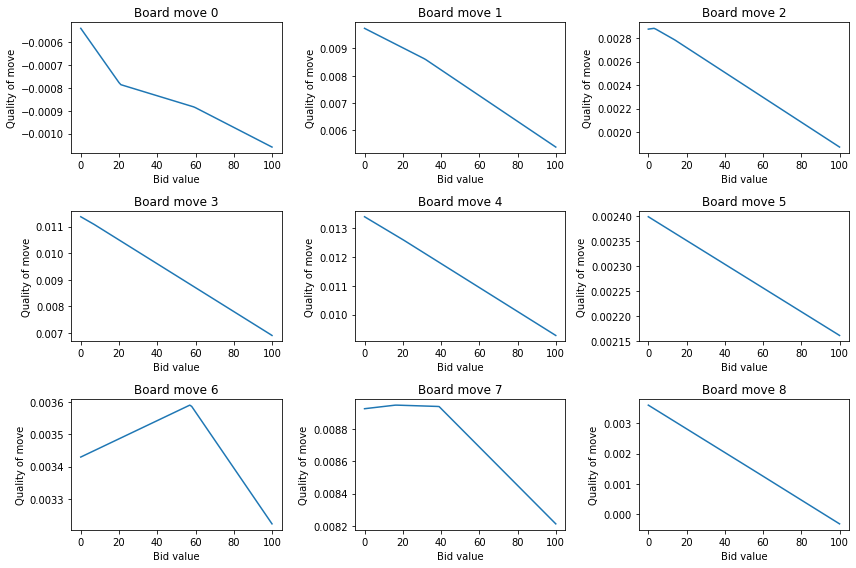

Animation of critic values saved!
Episode #1600  |  Val. Score: -0.10   |  Avg. Val. Score: -0.33  |  Epsilon: 0.202
                  Actor Loss: -2.889  |  Critic Loss: +0.848     |  Time Elapsed: 1697.57s
Episode #1700  |  Val. Score: -0.40   |  Avg. Val. Score: -0.33  |  Epsilon: 0.183
                  Actor Loss: -2.942  |  Critic Loss: +1.068     |  Time Elapsed: 1813.08s
Episode #1800  |  Val. Score: +0.20   |  Avg. Val. Score: -0.30  |  Epsilon: 0.165
                  Actor Loss: -2.965  |  Critic Loss: +1.127     |  Time Elapsed: 1923.20s
Episode #1900  |  Val. Score: -0.20   |  Avg. Val. Score: -0.29  |  Epsilon: 0.149
                  Actor Loss: -2.926  |  Critic Loss: +1.160     |  Time Elapsed: 2037.26s
Episode #2000  |  Val. Score: -0.20   |  Avg. Val. Score: -0.29  |  Epsilon: 0.135
                  Actor Loss: -2.852  |  Critic Loss: +1.180     |  Time Elapsed: 2156.16s
Checkpoint saved!


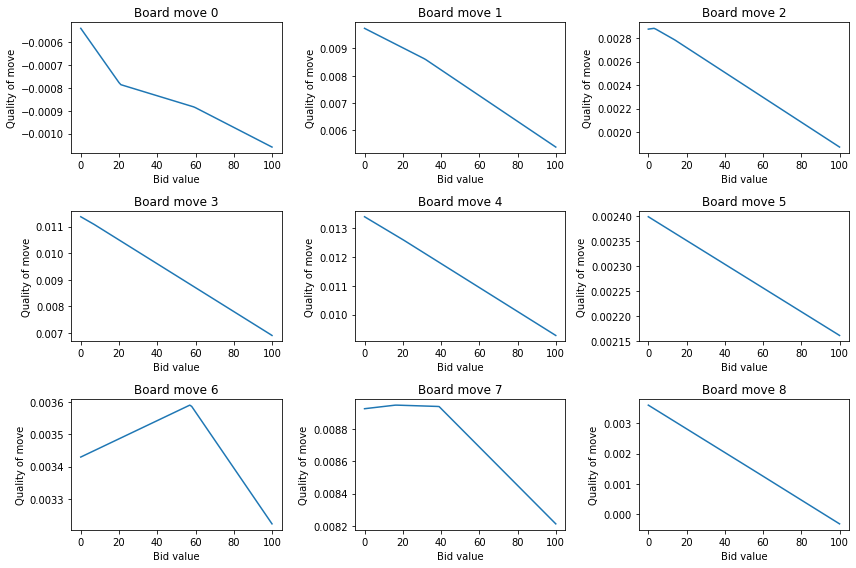

Animation of critic values saved!
Episode #2100  |  Val. Score: +0.10   |  Avg. Val. Score: -0.27  |  Epsilon: 0.122
                  Actor Loss: -2.924  |  Critic Loss: +0.874     |  Time Elapsed: 2283.65s
Episode #2200  |  Val. Score: +0.20   |  Avg. Val. Score: -0.25  |  Epsilon: 0.111
                  Actor Loss: -2.921  |  Critic Loss: +0.956     |  Time Elapsed: 2402.60s
Episode #2300  |  Val. Score: +0.30   |  Avg. Val. Score: -0.23  |  Epsilon: 0.100
                  Actor Loss: -2.884  |  Critic Loss: +0.991     |  Time Elapsed: 2523.69s
Episode #2400  |  Val. Score: -0.10   |  Avg. Val. Score: -0.22  |  Epsilon: 0.091
                  Actor Loss: -2.850  |  Critic Loss: +0.945     |  Time Elapsed: 2647.26s
Episode #2500  |  Val. Score: -0.10   |  Avg. Val. Score: -0.22  |  Epsilon: 0.082
                  Actor Loss: -2.761  |  Critic Loss: +0.868     |  Time Elapsed: 2764.54s
Checkpoint saved!


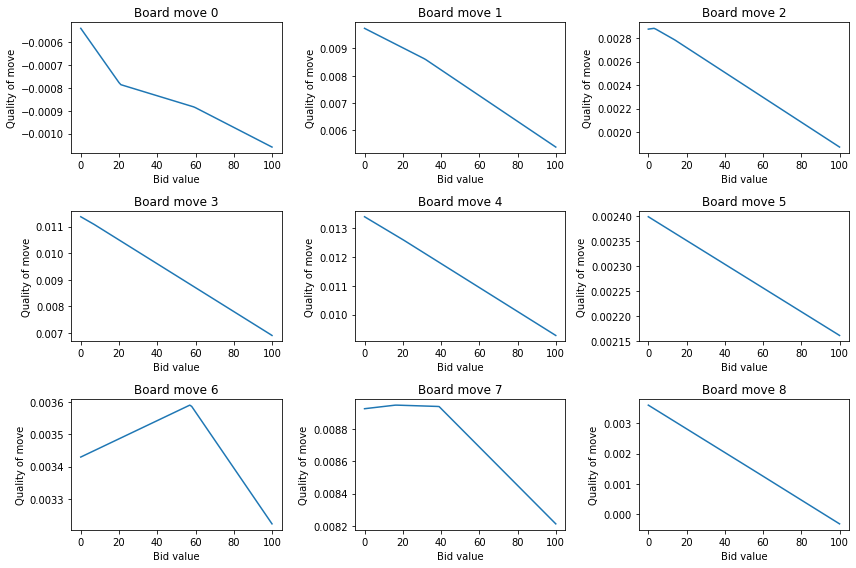

Animation of critic values saved!
Episode #2600  |  Val. Score: +0.30   |  Avg. Val. Score: -0.20  |  Epsilon: 0.074
                  Actor Loss: -2.717  |  Critic Loss: +0.916     |  Time Elapsed: 2886.30s
Episode #2700  |  Val. Score: -0.30   |  Avg. Val. Score: -0.20  |  Epsilon: 0.067
                  Actor Loss: -2.704  |  Critic Loss: +0.832     |  Time Elapsed: 2998.47s
Episode #2800  |  Val. Score: +0.60   |  Avg. Val. Score: -0.17  |  Epsilon: 0.061
                  Actor Loss: -2.682  |  Critic Loss: +0.864     |  Time Elapsed: 3109.84s
Episode #2900  |  Val. Score: +0.30   |  Avg. Val. Score: -0.16  |  Epsilon: 0.055
                  Actor Loss: -2.617  |  Critic Loss: +0.823     |  Time Elapsed: 3219.02s
Episode #3000  |  Val. Score: +0.00   |  Avg. Val. Score: -0.15  |  Epsilon: 0.050
                  Actor Loss: -2.576  |  Critic Loss: +0.755     |  Time Elapsed: 3332.68s
Checkpoint saved!


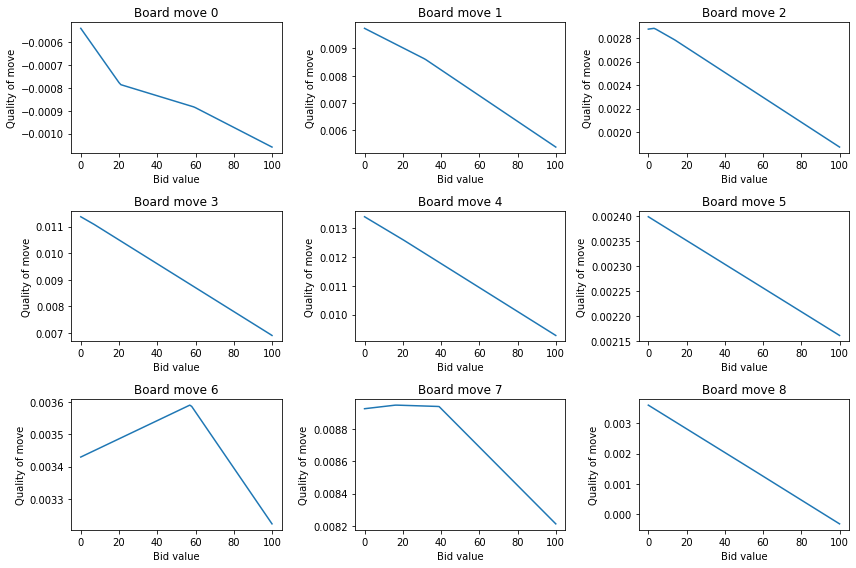

Animation of critic values saved!
Episode #3100  |  Val. Score: -0.30   |  Avg. Val. Score: -0.15  |  Epsilon: 0.045
                  Actor Loss: -2.598  |  Critic Loss: +0.740     |  Time Elapsed: 3462.59s
Episode #3200  |  Val. Score: +0.10   |  Avg. Val. Score: -0.15  |  Epsilon: 0.041
                  Actor Loss: -2.630  |  Critic Loss: +0.780     |  Time Elapsed: 3580.29s
Episode #3300  |  Val. Score: +0.00   |  Avg. Val. Score: -0.14  |  Epsilon: 0.037
                  Actor Loss: -2.609  |  Critic Loss: +0.828     |  Time Elapsed: 3697.38s
Episode #3400  |  Val. Score: +0.00   |  Avg. Val. Score: -0.14  |  Epsilon: 0.033
                  Actor Loss: -2.686  |  Critic Loss: +0.839     |  Time Elapsed: 3815.34s
Episode #3500  |  Val. Score: -0.10   |  Avg. Val. Score: -0.14  |  Epsilon: 0.030
                  Actor Loss: -2.885  |  Critic Loss: +0.911     |  Time Elapsed: 3923.78s
Checkpoint saved!


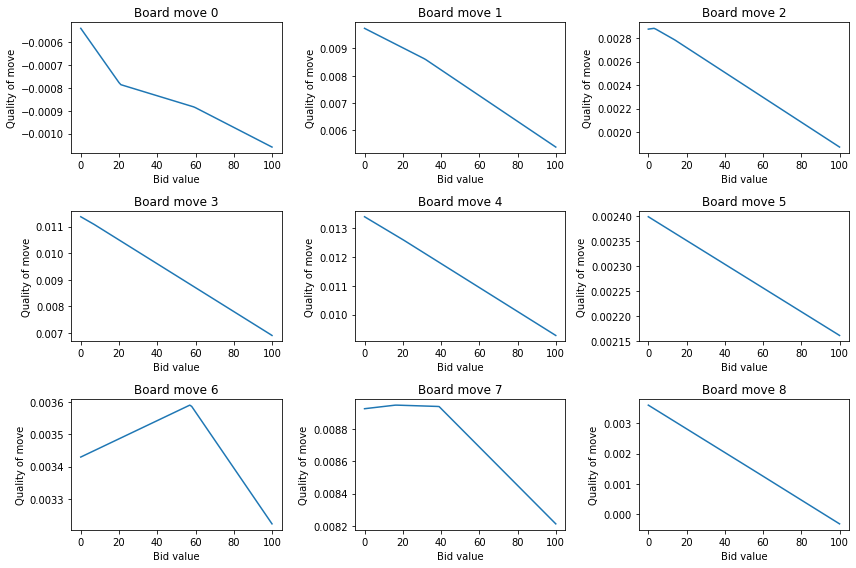

Animation of critic values saved!
Episode #3600  |  Val. Score: +0.10   |  Avg. Val. Score: -0.13  |  Epsilon: 0.027
                  Actor Loss: -2.969  |  Critic Loss: +0.946     |  Time Elapsed: 4033.42s
Episode #3700  |  Val. Score: -0.20   |  Avg. Val. Score: -0.13  |  Epsilon: 0.025
                  Actor Loss: -3.115  |  Critic Loss: +1.174     |  Time Elapsed: 4129.85s
Episode #3800  |  Val. Score: +0.30   |  Avg. Val. Score: -0.12  |  Epsilon: 0.022
                  Actor Loss: -3.282  |  Critic Loss: +1.303     |  Time Elapsed: 4233.07s
Episode #3900  |  Val. Score: +0.10   |  Avg. Val. Score: -0.12  |  Epsilon: 0.020
                  Actor Loss: -3.369  |  Critic Loss: +1.393     |  Time Elapsed: 4347.53s
Episode #4000  |  Val. Score: +0.10   |  Avg. Val. Score: -0.11  |  Epsilon: 0.018
                  Actor Loss: -3.422  |  Critic Loss: +1.260     |  Time Elapsed: 4464.19s
Checkpoint saved!


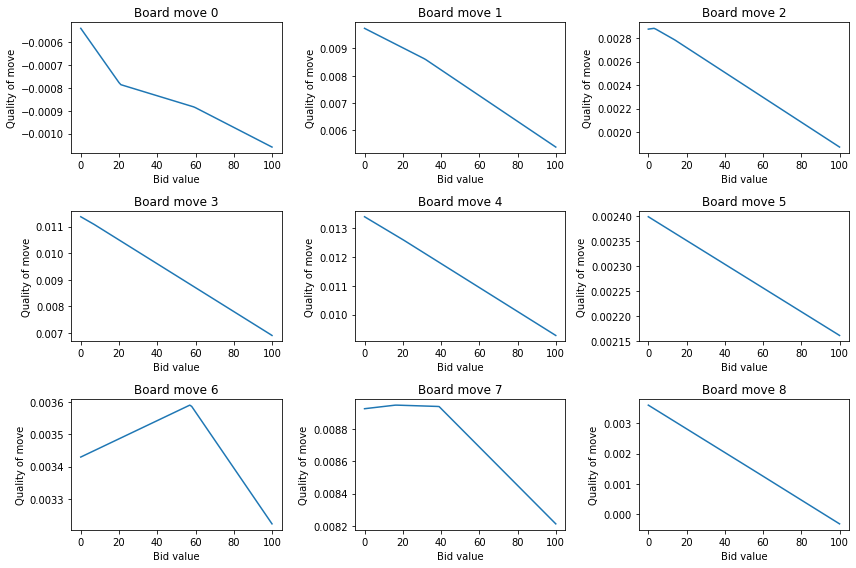

Animation of critic values saved!
Episode #4100  |  Val. Score: -0.20   |  Avg. Val. Score: -0.11  |  Epsilon: 0.017
                  Actor Loss: -3.512  |  Critic Loss: +1.484     |  Time Elapsed: 4595.39s
Episode #4200  |  Val. Score: -0.40   |  Avg. Val. Score: -0.12  |  Epsilon: 0.015
                  Actor Loss: -3.518  |  Critic Loss: +1.503     |  Time Elapsed: 4711.85s
Model saved!


In [10]:
n_episodes=10000
checkpoint_each=500
validate_each=100
n_episodes_validation=10
save_critic_value_each=100
save_animation_each=500
eps_start = 1.0
eps_end = 0.01
eps_decay = 0.999
drl_players = [DRLPlayer(i, controller.game, drl_agent, train_mode=True) for i in range(2)]
validation_scores, critic_values_by_episode = init_train(controller, drl_players, model_path='../checkpoints/model2.pt',
                    n_episodes=n_episodes, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=eps_start, eps_end=eps_end, eps_decay=eps_decay)


In [20]:
len(critic_values_by_episode)

42

In [21]:
final_validation_scores = validation_scores
final_critic_values_by_episode = critic_values_by_episode

Episode #24300  |  Val. Score: -0.90   |  Avg. Val. Score: -0.90  |  Epsilon: 0.010
                  Actor Loss: -15.252  |  Critic Loss: +25.786     |  Time Elapsed: 152.91s
Episode #24400  |  Val. Score: -0.20   |  Avg. Val. Score: -0.55  |  Epsilon: 0.010
                  Actor Loss: -15.639  |  Critic Loss: +28.425     |  Time Elapsed: 305.88s
Episode #24500  |  Val. Score: +0.30   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -15.844  |  Critic Loss: +26.145     |  Time Elapsed: 462.12s
Checkpoint saved!


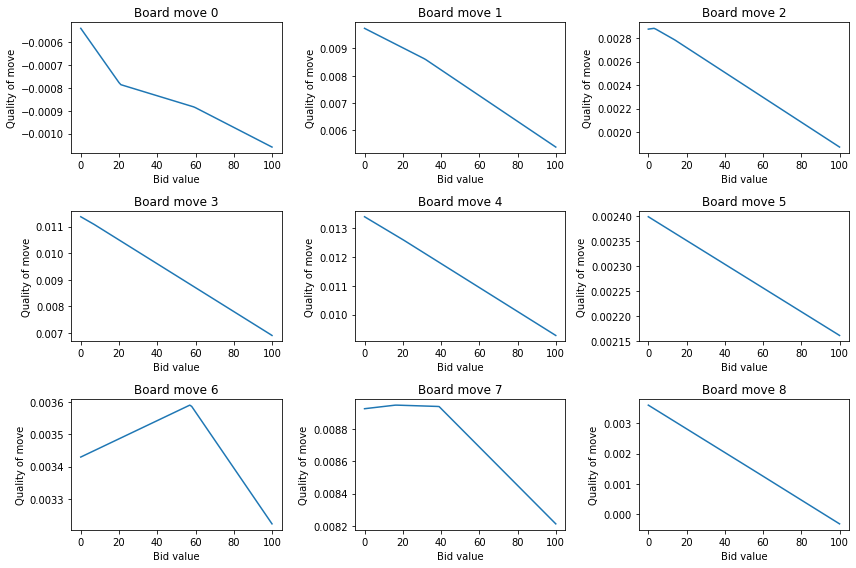

Animation of critic values saved!
Episode #24600  |  Val. Score: -0.10   |  Avg. Val. Score: -0.23  |  Epsilon: 0.010
                  Actor Loss: -15.800  |  Critic Loss: +25.193     |  Time Elapsed: 901.74s
Episode #24700  |  Val. Score: -0.20   |  Avg. Val. Score: -0.22  |  Epsilon: 0.010
                  Actor Loss: -15.421  |  Critic Loss: +23.078     |  Time Elapsed: 1057.98s
Episode #24800  |  Val. Score: +0.20   |  Avg. Val. Score: -0.15  |  Epsilon: 0.010
                  Actor Loss: -15.390  |  Critic Loss: +23.157     |  Time Elapsed: 1213.88s
Episode #24900  |  Val. Score: +0.30   |  Avg. Val. Score: -0.09  |  Epsilon: 0.010
                  Actor Loss: -15.460  |  Critic Loss: +25.744     |  Time Elapsed: 1353.47s
Episode #25000  |  Val. Score: +0.00   |  Avg. Val. Score: -0.08  |  Epsilon: 0.010
                  Actor Loss: -15.617  |  Critic Loss: +25.392     |  Time Elapsed: 1507.42s
Checkpoint saved!


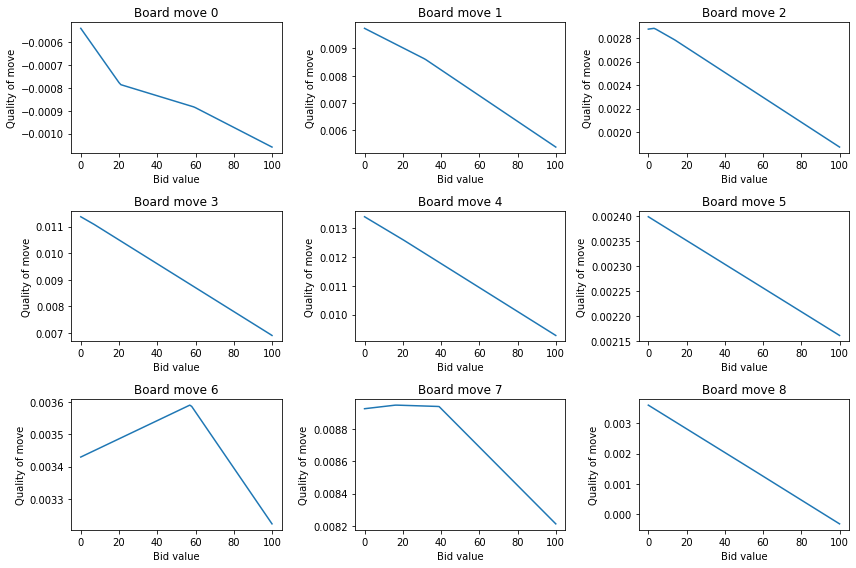

Animation of critic values saved!
Episode #25100  |  Val. Score: +0.10   |  Avg. Val. Score: -0.06  |  Epsilon: 0.010
                  Actor Loss: -15.870  |  Critic Loss: +23.079     |  Time Elapsed: 1944.96s
Episode #25200  |  Val. Score: -0.20   |  Avg. Val. Score: -0.07  |  Epsilon: 0.010
                  Actor Loss: -15.364  |  Critic Loss: +25.336     |  Time Elapsed: 2095.03s
Episode #25300  |  Val. Score: +0.20   |  Avg. Val. Score: -0.05  |  Epsilon: 0.010
                  Actor Loss: -15.014  |  Critic Loss: +24.488     |  Time Elapsed: 2198.40s
Episode #25400  |  Val. Score: -0.30   |  Avg. Val. Score: -0.07  |  Epsilon: 0.010
                  Actor Loss: -14.883  |  Critic Loss: +25.132     |  Time Elapsed: 2296.03s
Episode #25500  |  Val. Score: -0.30   |  Avg. Val. Score: -0.08  |  Epsilon: 0.010
                  Actor Loss: -14.603  |  Critic Loss: +23.742     |  Time Elapsed: 2396.01s
Checkpoint saved!


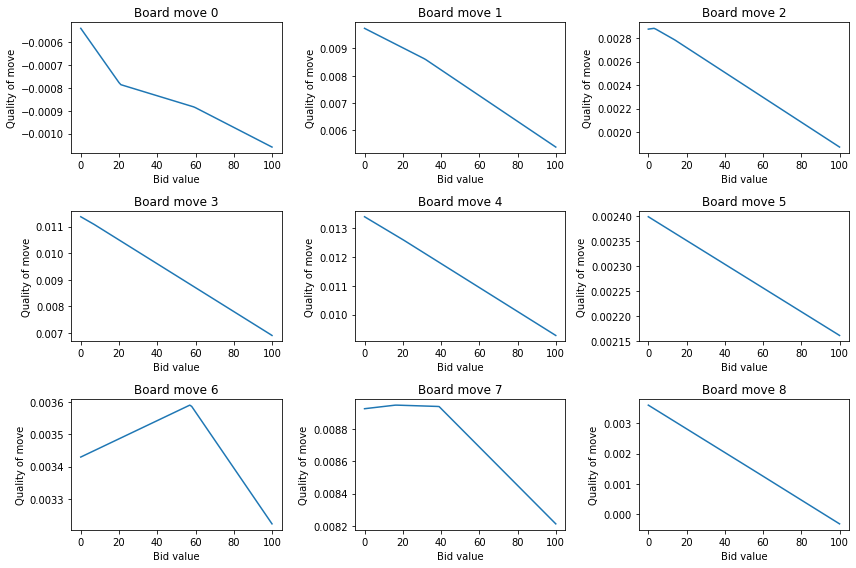

Animation of critic values saved!
Episode #25600  |  Val. Score: -0.60   |  Avg. Val. Score: -0.12  |  Epsilon: 0.010
                  Actor Loss: -14.335  |  Critic Loss: +22.918     |  Time Elapsed: 2782.03s
Episode #25700  |  Val. Score: -0.30   |  Avg. Val. Score: -0.13  |  Epsilon: 0.010
                  Actor Loss: -14.195  |  Critic Loss: +21.090     |  Time Elapsed: 2902.24s
Episode #25800  |  Val. Score: -0.20   |  Avg. Val. Score: -0.14  |  Epsilon: 0.010
                  Actor Loss: -13.914  |  Critic Loss: +18.205     |  Time Elapsed: 3061.52s
Episode #25900  |  Val. Score: -0.20   |  Avg. Val. Score: -0.14  |  Epsilon: 0.010
                  Actor Loss: -13.311  |  Critic Loss: +19.431     |  Time Elapsed: 3220.73s
Episode #26000  |  Val. Score: -0.10   |  Avg. Val. Score: -0.14  |  Epsilon: 0.010
                  Actor Loss: -12.896  |  Critic Loss: +18.569     |  Time Elapsed: 3382.49s
Checkpoint saved!


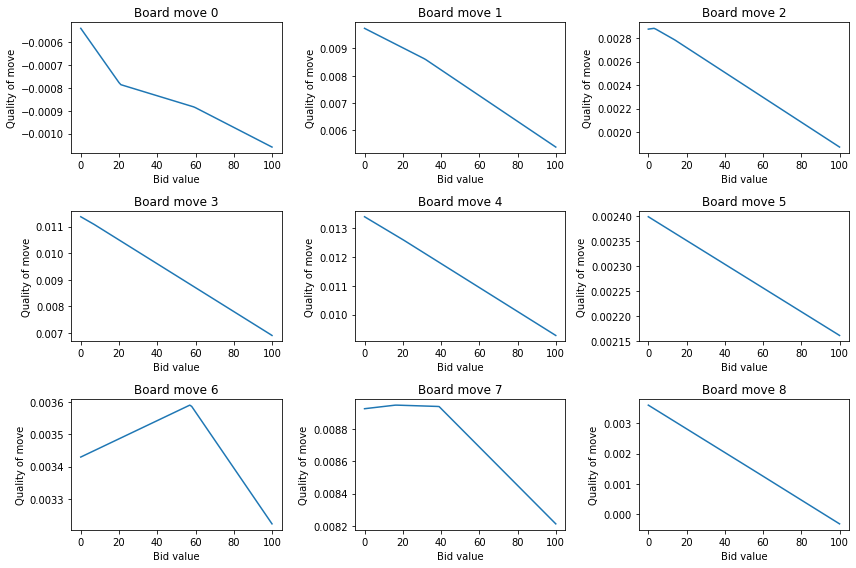

Animation of critic values saved!
Episode #26100  |  Val. Score: -0.40   |  Avg. Val. Score: -0.15  |  Epsilon: 0.010
                  Actor Loss: -12.549  |  Critic Loss: +16.684     |  Time Elapsed: 3839.21s
Episode #26200  |  Val. Score: -0.40   |  Avg. Val. Score: -0.17  |  Epsilon: 0.010
                  Actor Loss: -12.209  |  Critic Loss: +16.393     |  Time Elapsed: 4003.26s
Episode #26300  |  Val. Score: -0.40   |  Avg. Val. Score: -0.18  |  Epsilon: 0.010
                  Actor Loss: -12.089  |  Critic Loss: +13.968     |  Time Elapsed: 4171.18s
Episode #26400  |  Val. Score: -0.30   |  Avg. Val. Score: -0.18  |  Epsilon: 0.010
                  Actor Loss: -12.040  |  Critic Loss: +13.939     |  Time Elapsed: 4322.18s
Episode #26500  |  Val. Score: -0.20   |  Avg. Val. Score: -0.18  |  Epsilon: 0.010
                  Actor Loss: -11.703  |  Critic Loss: +13.270     |  Time Elapsed: 4480.84s
Checkpoint saved!


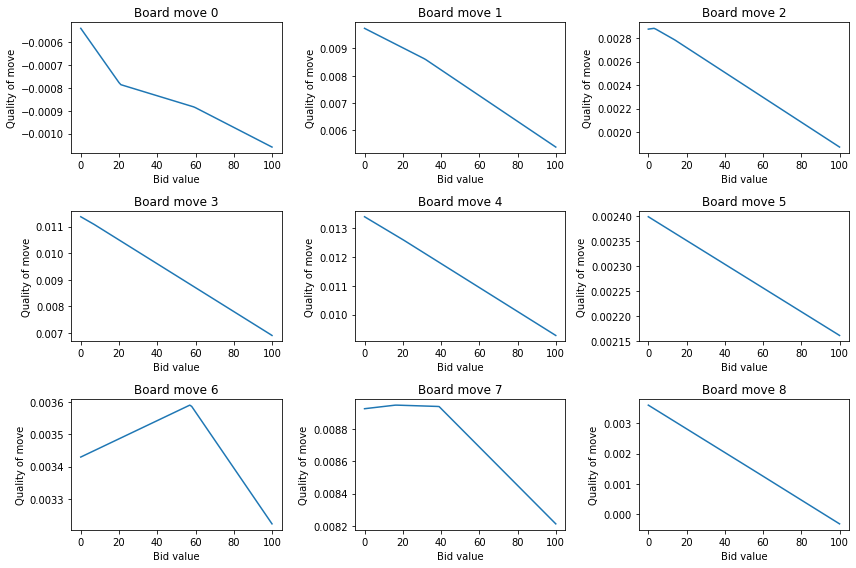

Animation of critic values saved!
Episode #26600  |  Val. Score: -0.50   |  Avg. Val. Score: -0.20  |  Epsilon: 0.010
                  Actor Loss: -11.666  |  Critic Loss: +13.728     |  Time Elapsed: 4944.86s
Episode #26700  |  Val. Score: +0.10   |  Avg. Val. Score: -0.18  |  Epsilon: 0.010
                  Actor Loss: -11.396  |  Critic Loss: +14.002     |  Time Elapsed: 5104.54s
Episode #26800  |  Val. Score: -0.10   |  Avg. Val. Score: -0.18  |  Epsilon: 0.010
                  Actor Loss: -11.499  |  Critic Loss: +13.995     |  Time Elapsed: 5273.42s
Episode #26900  |  Val. Score: -0.30   |  Avg. Val. Score: -0.19  |  Epsilon: 0.010
                  Actor Loss: -11.361  |  Critic Loss: +13.858     |  Time Elapsed: 5441.77s
Episode #27000  |  Val. Score: -0.30   |  Avg. Val. Score: -0.19  |  Epsilon: 0.010
                  Actor Loss: -11.636  |  Critic Loss: +12.868     |  Time Elapsed: 5612.52s
Checkpoint saved!


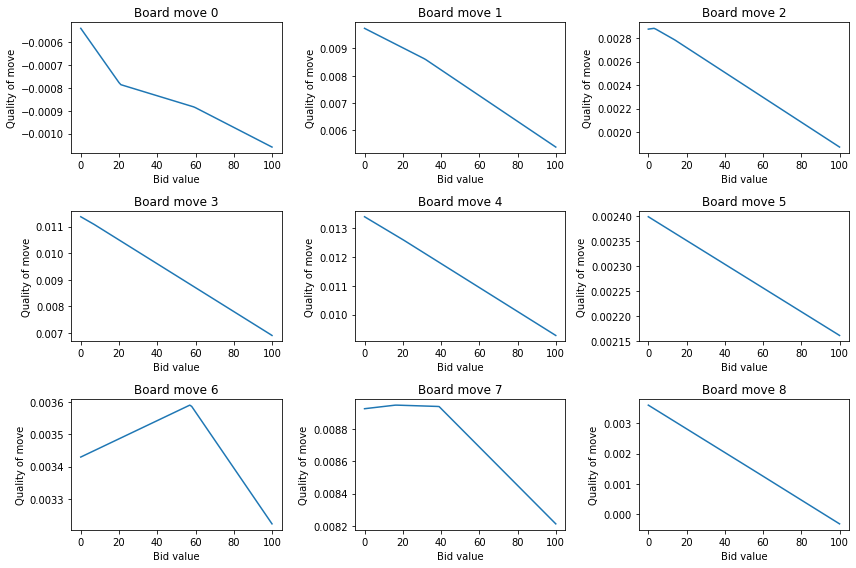

Animation of critic values saved!
Episode #27100  |  Val. Score: +0.00   |  Avg. Val. Score: -0.18  |  Epsilon: 0.010
                  Actor Loss: -11.467  |  Critic Loss: +14.359     |  Time Elapsed: 6081.42s
Episode #27200  |  Val. Score: +0.20   |  Avg. Val. Score: -0.17  |  Epsilon: 0.010
                  Actor Loss: -11.313  |  Critic Loss: +12.706     |  Time Elapsed: 6243.33s
Episode #27300  |  Val. Score: -0.60   |  Avg. Val. Score: -0.18  |  Epsilon: 0.010
                  Actor Loss: -11.001  |  Critic Loss: +13.958     |  Time Elapsed: 6405.25s
Episode #27400  |  Val. Score: +0.00   |  Avg. Val. Score: -0.18  |  Epsilon: 0.010
                  Actor Loss: -11.107  |  Critic Loss: +13.149     |  Time Elapsed: 6577.90s
Episode #27500  |  Val. Score: -0.70   |  Avg. Val. Score: -0.19  |  Epsilon: 0.010
                  Actor Loss: -11.145  |  Critic Loss: +12.213     |  Time Elapsed: 6748.00s
Checkpoint saved!


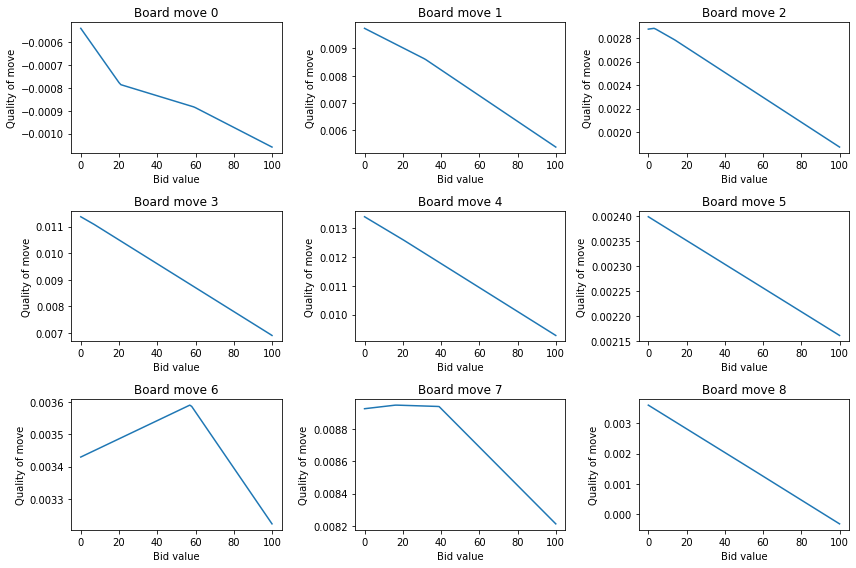

Animation of critic values saved!
Episode #27600  |  Val. Score: -0.40   |  Avg. Val. Score: -0.20  |  Epsilon: 0.010
                  Actor Loss: -11.088  |  Critic Loss: +13.737     |  Time Elapsed: 7228.55s
Episode #27700  |  Val. Score: -0.40   |  Avg. Val. Score: -0.21  |  Epsilon: 0.010
                  Actor Loss: -11.088  |  Critic Loss: +11.603     |  Time Elapsed: 7406.31s
Episode #27800  |  Val. Score: -0.80   |  Avg. Val. Score: -0.22  |  Epsilon: 0.010
                  Actor Loss: -11.116  |  Critic Loss: +12.904     |  Time Elapsed: 7583.88s
Episode #27900  |  Val. Score: -0.40   |  Avg. Val. Score: -0.23  |  Epsilon: 0.010
                  Actor Loss: -11.224  |  Critic Loss: +11.434     |  Time Elapsed: 7752.48s
Episode #28000  |  Val. Score: -0.30   |  Avg. Val. Score: -0.23  |  Epsilon: 0.010
                  Actor Loss: -11.313  |  Critic Loss: +12.321     |  Time Elapsed: 7927.13s
Checkpoint saved!


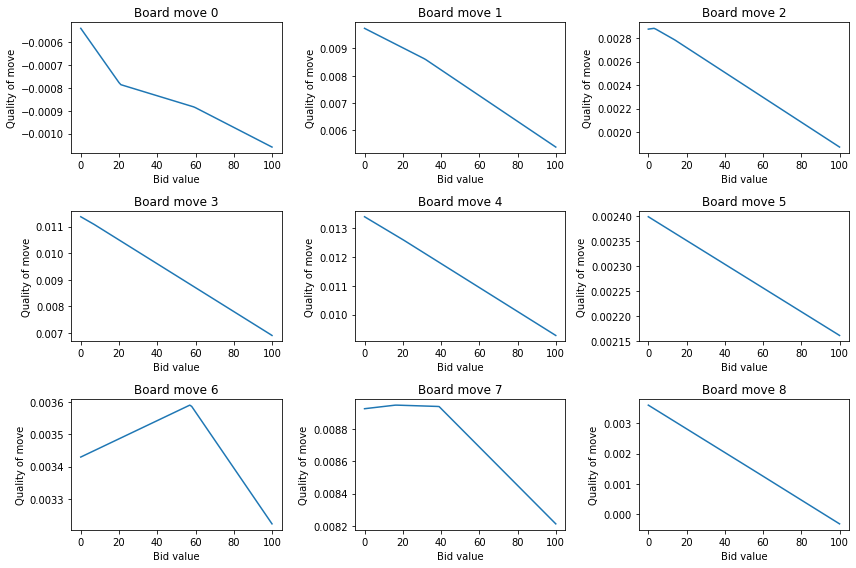

Animation of critic values saved!
Episode #28100  |  Val. Score: -0.10   |  Avg. Val. Score: -0.23  |  Epsilon: 0.010
                  Actor Loss: -10.961  |  Critic Loss: +12.802     |  Time Elapsed: 8412.51s
Episode #28200  |  Val. Score: +0.10   |  Avg. Val. Score: -0.22  |  Epsilon: 0.010
                  Actor Loss: -11.076  |  Critic Loss: +11.463     |  Time Elapsed: 8591.48s
Episode #28300  |  Val. Score: -0.70   |  Avg. Val. Score: -0.23  |  Epsilon: 0.010
                  Actor Loss: -10.958  |  Critic Loss: +10.698     |  Time Elapsed: 8767.76s
Episode #28400  |  Val. Score: -0.40   |  Avg. Val. Score: -0.23  |  Epsilon: 0.010
                  Actor Loss: -11.010  |  Critic Loss: +11.367     |  Time Elapsed: 8947.65s
Episode #28500  |  Val. Score: -0.50   |  Avg. Val. Score: -0.24  |  Epsilon: 0.010
                  Actor Loss: -11.305  |  Critic Loss: +12.121     |  Time Elapsed: 9125.15s
Checkpoint saved!


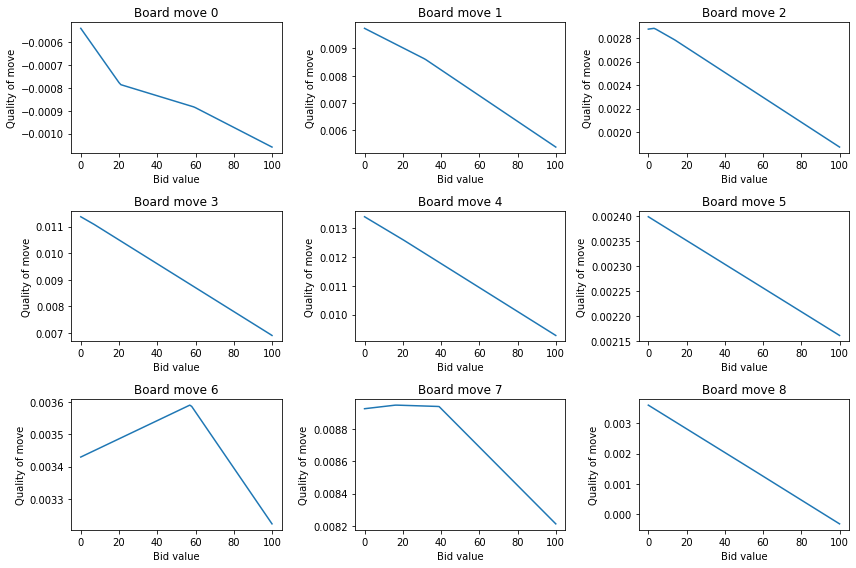

Animation of critic values saved!
Episode #28600  |  Val. Score: -0.60   |  Avg. Val. Score: -0.25  |  Epsilon: 0.010
                  Actor Loss: -11.652  |  Critic Loss: +14.001     |  Time Elapsed: 9626.16s
Episode #28700  |  Val. Score: -0.60   |  Avg. Val. Score: -0.26  |  Epsilon: 0.010
                  Actor Loss: -11.716  |  Critic Loss: +14.539     |  Time Elapsed: 9812.40s
Episode #28800  |  Val. Score: -0.10   |  Avg. Val. Score: -0.25  |  Epsilon: 0.010
                  Actor Loss: -12.147  |  Critic Loss: +12.778     |  Time Elapsed: 9993.00s
Episode #28900  |  Val. Score: -0.80   |  Avg. Val. Score: -0.26  |  Epsilon: 0.010
                  Actor Loss: -12.361  |  Critic Loss: +15.845     |  Time Elapsed: 10179.43s
Episode #29000  |  Val. Score: -0.20   |  Avg. Val. Score: -0.26  |  Epsilon: 0.010
                  Actor Loss: -12.891  |  Critic Loss: +16.149     |  Time Elapsed: 10363.44s
Checkpoint saved!


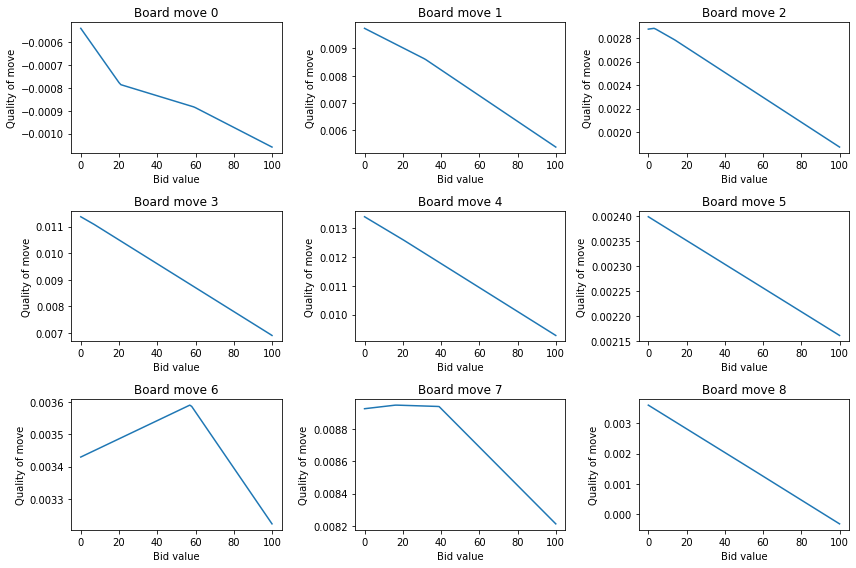

Animation of critic values saved!
Episode #29100  |  Val. Score: -0.20   |  Avg. Val. Score: -0.26  |  Epsilon: 0.010
                  Actor Loss: -13.280  |  Critic Loss: +17.505     |  Time Elapsed: 10869.51s
Episode #29200  |  Val. Score: -0.60   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -13.863  |  Critic Loss: +19.500     |  Time Elapsed: 11046.33s
Episode #29300  |  Val. Score: -0.20   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -14.308  |  Critic Loss: +22.908     |  Time Elapsed: 11225.71s
Episode #29400  |  Val. Score: -0.30   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -14.873  |  Critic Loss: +20.660     |  Time Elapsed: 11394.19s
Episode #29500  |  Val. Score: -0.40   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -14.889  |  Critic Loss: +23.086     |  Time Elapsed: 11562.91s
Checkpoint saved!


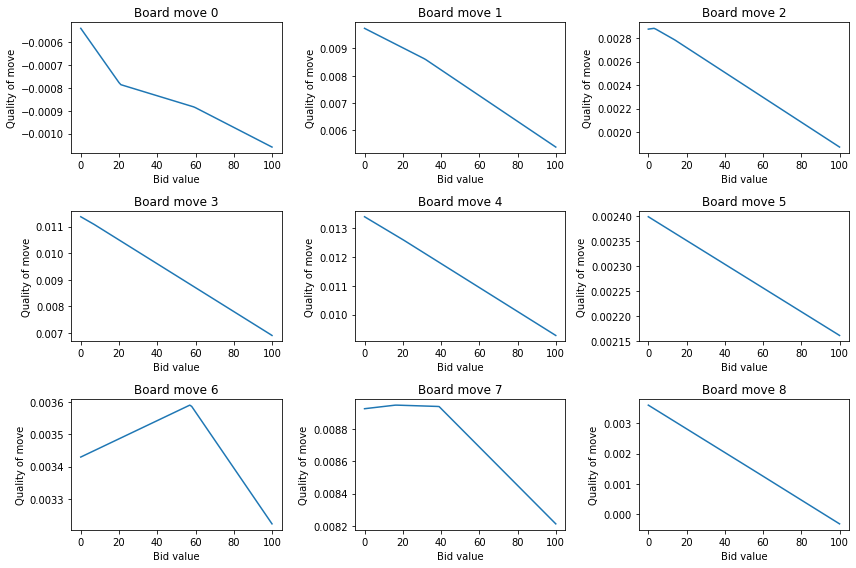

Animation of critic values saved!
Episode #29600  |  Val. Score: -0.40   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -15.146  |  Critic Loss: +24.506     |  Time Elapsed: 12050.90s
Episode #29700  |  Val. Score: +0.00   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -15.612  |  Critic Loss: +22.986     |  Time Elapsed: 12218.91s
Episode #29800  |  Val. Score: -0.30   |  Avg. Val. Score: -0.27  |  Epsilon: 0.010
                  Actor Loss: -15.904  |  Critic Loss: +24.994     |  Time Elapsed: 12388.52s
Episode #29900  |  Val. Score: +0.00   |  Avg. Val. Score: -0.26  |  Epsilon: 0.010
                  Actor Loss: -15.675  |  Critic Loss: +27.141     |  Time Elapsed: 12559.21s
Episode #30000  |  Val. Score: -0.20   |  Avg. Val. Score: -0.26  |  Epsilon: 0.010
                  Actor Loss: -15.132  |  Critic Loss: +24.178     |  Time Elapsed: 12728.82s
Checkpoint saved!


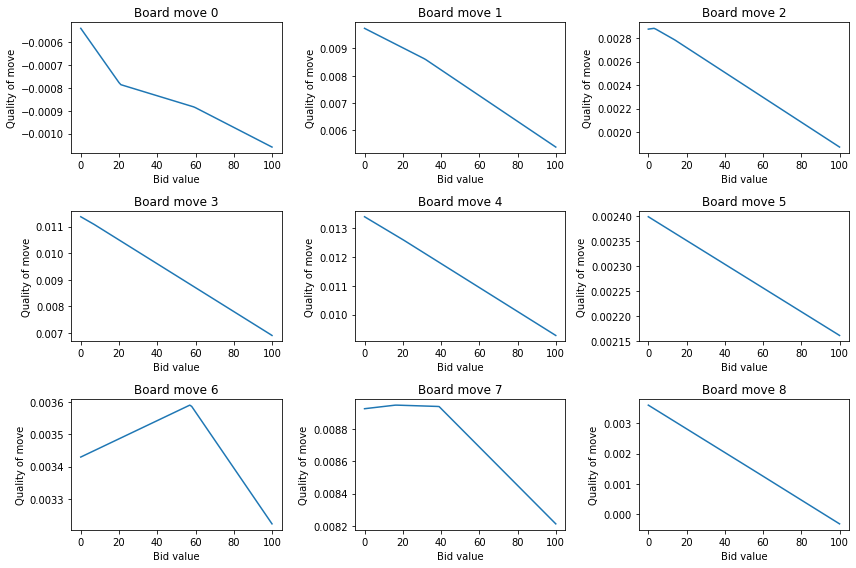

Animation of critic values saved!
Model saved!


In [30]:
# Continue training
validation_scores_continued, critic_values_by_episode_continued = init_train(controller, drl_players,
                    start_epoch=24201, critic_values_by_episode=critic_values_by_episode, model_path='../checkpoints/model2.pt',
                    n_episodes=5800, checkpoint_each=checkpoint_each, validate_each=validate_each,
                    n_episodes_validation=n_episodes_validation, save_animation_each=save_animation_each,
                    save_critic_value_each=save_critic_value_each, eps_start=0.01, eps_end=eps_end, eps_decay=eps_decay)

In [31]:
final_validation_scores += validation_scores_continued
final_critic_values_by_episode += critic_values_by_episode_continued

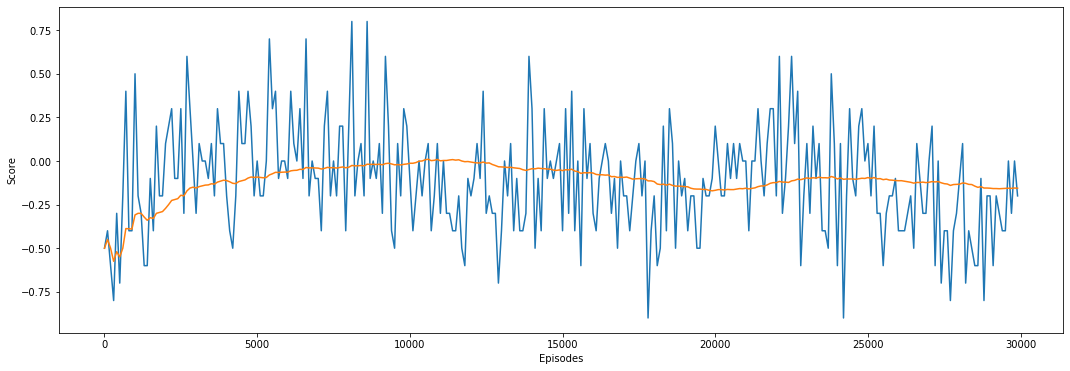

In [32]:
plot_scores(final_validation_scores, validate_each)

In [33]:
drl_agent.save_model('../checkpoints/model_final2.pt')

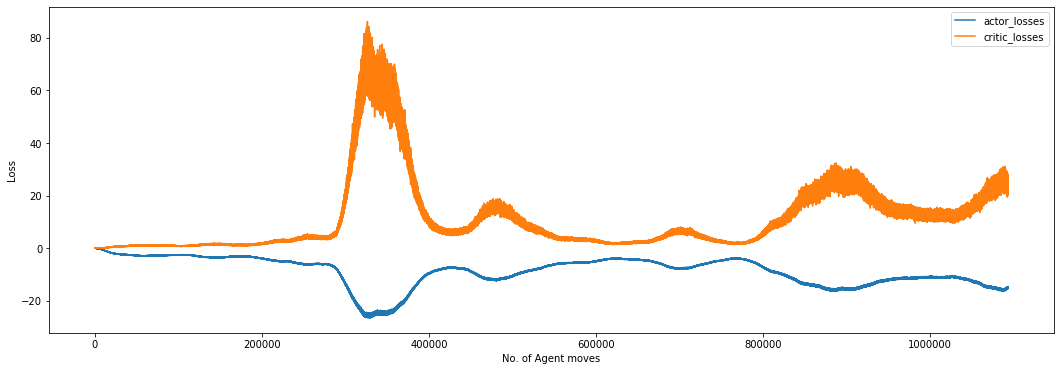

In [34]:
# Plot loss functions
losses = drl_agent.get_losses()
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(losses['actor_losses'], label='actor_losses')
ax.plot(losses['critic_losses'], label='critic_losses')
ax.set_xlabel('No. of Agent moves')
ax.set_ylabel('Loss')
# ax.plot(list((critic_loss - actor_loss) for critic_loss, actor_loss in zip(losses['critic_losses'][:], losses['actor_losses'][:])), label='diff_losses')
plt.legend(loc='best')
plt.show();

In [28]:
controller.reset_game()

Select one of the following players to be player 1
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 0
current directory: C:\Users\tiago\dev\ufrj\gambling-tic-tac-toe\src
initial_checkpoint_path: ../checkpoints/checkpoint2.pt
self.t_step 4
Select one of the following players to be player 2
0 - ./models/players\drl_player.py
1 - ./models/players\human_player.py
2 - ./models/players\random_player.py
Input desired player number: 1
                  1 | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---+---
                  7 | 8 | 9 
Player 1 (X): 100           Player 2 (O): 100

Player 1 DRLPlayer(X) bidding...
Player 2 HumanPlayer(O) bidding...
50
Player 1 DRLPlayer(X) bid: 75  |  Player 2 HumanPlayer(O) bid: 50  |  
Player 1 DRLPlayer(X) won the bet
                  1 | 2 | 3 
                 ---+---+---
                  4 | 5 | 6 
                 ---+---